In [2]:
# check package versions
import sys
import keras
import cv2
import numpy
import matplotlib
import skimage

print('Python: {}'.format(sys.version))
print('Keras: {}'.format(keras.__version__))
print('OpenCV: {}'.format(cv2.__version__))
print('NumPy: {}'.format(numpy.__version__))
print('Matplotlib: {}'.format(matplotlib.__version__))
print('Scikit-Image: {}'.format(skimage.__version__))

Python: 3.7.10 (default, Feb 20 2021, 21:17:23) 
[GCC 7.5.0]
Keras: 2.4.3
OpenCV: 4.1.2
NumPy: 1.19.5
Matplotlib: 3.2.2
Scikit-Image: 0.16.2


In [3]:
from keras.models import Sequential
from keras.layers import Conv2D
from keras.optimizers import Adam
from skimage.measure import compare_ssim as ssim
from matplotlib import pyplot as plt
import cv2
import numpy as np
import math
import os

%matplotlib inline

In [4]:
# define a function for peak signal-to-noise ratio (PSNR)
def psnr(target, ref):
         
    # assume RGB image
    target_data = target.astype(float)
    ref_data = ref.astype(float)

    diff = ref_data - target_data
    diff = diff.flatten('C')

    rmse = math.sqrt(np.mean(diff ** 2.))

    return 20 * math.log10(255. / rmse)

# define function for mean squared error (MSE)
def mse(target, ref):
    # the MSE between the two images is the sum of the squared difference between the two images
    err = np.sum((target.astype('float') - ref.astype('float')) ** 2)
    err /= float(target.shape[0] * target.shape[1])
    
    return err

# define function that combines all three image quality metrics
def compare_images(target, ref):
    scores = []
    scores.append(psnr(target, ref))
    scores.append(mse(target, ref))
    scores.append(ssim(target, ref, multichannel =True))
    
    return scores

In [5]:
# prepare degraded images by introducing quality distortions via resizing

def prepare_images(path, factor):
    os.mkdir("images") if not os.path.isdir("images") else None

    # loop through the files in the directory
    for file in os.listdir(path):
        
        # open the file
        img = cv2.imread(path + file)
        
        # find old and new image dimensions
        h, w, _ = img.shape
        new_height = int(h / factor)
        new_width = int(w / factor)
        
        # resize the image - down
        img = cv2.resize(img, (new_width, new_height), interpolation = cv2.INTER_LINEAR)
        
        # resize the image - up
        img = cv2.resize(img, (w, h), interpolation = cv2.INTER_LINEAR)
        
        # save the image
        print('Saving {}'.format(file))
        cv2.imwrite('images/{}'.format(file), img)
prepare_images('source/', 2)

Saving bird_GT.bmp
Saving flowers.bmp
Saving coastguard.bmp
Saving bridge.bmp
Saving pepper.bmp
Saving face.bmp
Saving barbara.bmp
Saving foreman.bmp
Saving butterfly_GT.bmp
Saving lenna.bmp
Saving baby_GT.bmp
Saving zebra.bmp
Saving ppt3.bmp
Saving comic.bmp
Saving monarch.bmp
Saving woman_GT.bmp
Saving man.bmp
Saving head_GT.bmp
Saving baboon.bmp


In [6]:
# test the generated images using the image quality metrics

for file in os.listdir('images/'):
    
    # open target and reference images
    target = cv2.imread('images/{}'.format(file))
    ref = cv2.imread('source/{}'.format(file))
    
    # calculate score
    scores = compare_images(target, ref)

    # print all three scores with new line characters (\n) 
    print('{}\nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(file, scores[0], scores[1], scores[2]))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


bird_GT.bmp
PSNR: 32.896644728720005
MSE: 100.12375819830247
SSIM: 0.9533644866026473

flowers.bmp
PSNR: 27.454504805386144
MSE: 350.55093922651935
SSIM: 0.8697286286974628

coastguard.bmp
PSNR: 27.161600663887082
MSE: 375.00887784090907
SSIM: 0.756950063354931

bridge.bmp
PSNR: 25.850528790115554
MSE: 507.1643714904785
SSIM: 0.7804245912255268

pepper.bmp
PSNR: 29.88947161686106
MSE: 200.1033935546875
SSIM: 0.8357937568464359

face.bmp
PSNR: 30.99220650287191
MSE: 155.23189718546524
SSIM: 0.8008439492289884

barbara.bmp
PSNR: 25.906629837568126
MSE: 500.65508535879627
SSIM: 0.8098632646406401

foreman.bmp
PSNR: 30.14456532664372
MSE: 188.6883483270202
SSIM: 0.933268417388899

butterfly_GT.bmp
PSNR: 24.782076560337416
MSE: 648.6254119873047
SSIM: 0.8791344763843051

lenna.bmp
PSNR: 31.47349297867539
MSE: 138.94800567626953
SSIM: 0.8460989200521499

baby_GT.bmp
PSNR: 34.371806409661986
MSE: 71.28874588012695
SSIM: 0.9356987872724932

zebra.bmp
PSNR: 27.909840639329513
MSE: 315.658545952

In [7]:
# define the SRCNN model
def model():
    
    # define model type
    SRCNN = Sequential()
    
    # add model layers
    SRCNN.add(Conv2D(filters=128, kernel_size = (9, 9), kernel_initializer='glorot_uniform',
                     activation='relu', padding='valid', use_bias=True, input_shape=(None, None, 1)))
    SRCNN.add(Conv2D(filters=64, kernel_size = (3, 3), kernel_initializer='glorot_uniform',
                     activation='relu', padding='same', use_bias=True))
    SRCNN.add(Conv2D(filters=1, kernel_size = (5, 5), kernel_initializer='glorot_uniform',
                     activation='linear', padding='valid', use_bias=True))
    
    # define optimizer
    adam = Adam(lr=0.0003)
    
    # compile model
    SRCNN.compile(optimizer=adam, loss='mean_squared_error', metrics=['mean_squared_error'])
    
    return SRCNN

In [8]:
# define necessary image processing functions

def shave(image, border):
    img = image[border: -border, border: -border]
    return img
# define main prediction function

def predict(image_path):
    
    # load the srcnn model with weights
    srcnn = model()
    srcnn.load_weights('3051crop_weight_200.h5')
    
    # load the degraded and reference images
    path, file = os.path.split(image_path)
    degraded = cv2.imread(image_path)
    ref = cv2.imread('source/{}'.format(file))
    
    
    # convert the image to YCrCb - (srcnn trained on Y channel)
    temp = cv2.cvtColor(degraded, cv2.COLOR_BGR2YCrCb)
    
    # create image slice and normalize  
    Y = numpy.zeros((1, temp.shape[0], temp.shape[1], 1), dtype=float)
    Y[0, :, :, 0] = temp[:, :, 0].astype(float) / 255
    
    # perform super-resolution with srcnn
    pre = srcnn.predict(Y, batch_size=1)
    
    # post-process output
    pre *= 255
    pre[pre[:] > 255] = 255
    pre[pre[:] < 0] = 0
    pre = pre.astype(np.uint8)
    
    # copy Y channel back to image and convert to BGR
    temp = shave(temp, 6)
    temp[:, :, 0] = pre[0, :, :, 0]
    output = cv2.cvtColor(temp, cv2.COLOR_YCrCb2BGR)
    
    # remove border from reference and degraged image
    ref = shave(ref.astype(np.uint8), 6)
    degraded = shave(degraded.astype(np.uint8), 6)
    
    # image quality calculations
    scores = []
    scores.append(compare_images(degraded, ref))
    scores.append(compare_images(output, ref))
    
    # return images and scores
    return ref, degraded, output, scores


In [79]:
def crop_image(img):
    height, width = img.shape[0], img.shape[1]
    first = (max(height, width) - min(height, width)) // 2 
    second = first + min(height, width)
    if width > height:
        return img[:, first:second]
    else:
        return img[first:second, :]

In [28]:
def choose_quarter(size, borders):
    left, right, bottom, top = borders
    if left < size - right - 1:
        if top > size - 1 - bottom:
            return [0.6, 0.6, 0.35, 0.35]
        else:
            return [0.6, 0.05, 0.35, 0.35]
    else:
        if top > size - 1 - bottom:
            return [0.05, 0.6, 0.35, 0.35]
        else:
            return [0.05, 0.05, 0.35, 0.35]


In [55]:
def display_images(image_path, borders = [0, 50, 50, 0], save_path = None):
    # preparations
    ref, degraded, output, scores = predict(image_path)
    
    # crop images
    ref = crop_image(ref)
    degraded = crop_image(degraded)
    output = crop_image(output)
    size = ref.shape[0]

    # display images
    fig, axs = plt.subplots(1, 3, figsize=(26, 8))
    titles = ['Original', 'Degraded', 'SRCNN']
    images = [ref, degraded, output]
    for i in range(3):
        axs[i].imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
        axs[i].set_title(titles[i])
        axins = axs[i].inset_axes(choose_quarter(size, borders))
        axins.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
        axins.set_xlim(borders[0], borders[1])
        axins.set_ylim(borders[2], borders[3])
        axins.set_xticks([])
        axins.set_yticks([])
        rectangle, lines = axs[i].indicate_inset_zoom(axins, linewidth = 4, edgecolor='red')
        for line in lines:
            line.set_visible(False)
        
    # save images
    if save_path is not None:
        _, file = os.path.split(image_path)
        os.mkdir(save_path) if not os.path.isdir(save_path) else None
        fig.savefig(save_path + '/{}.png'.format(os.path.splitext(file)[0]))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


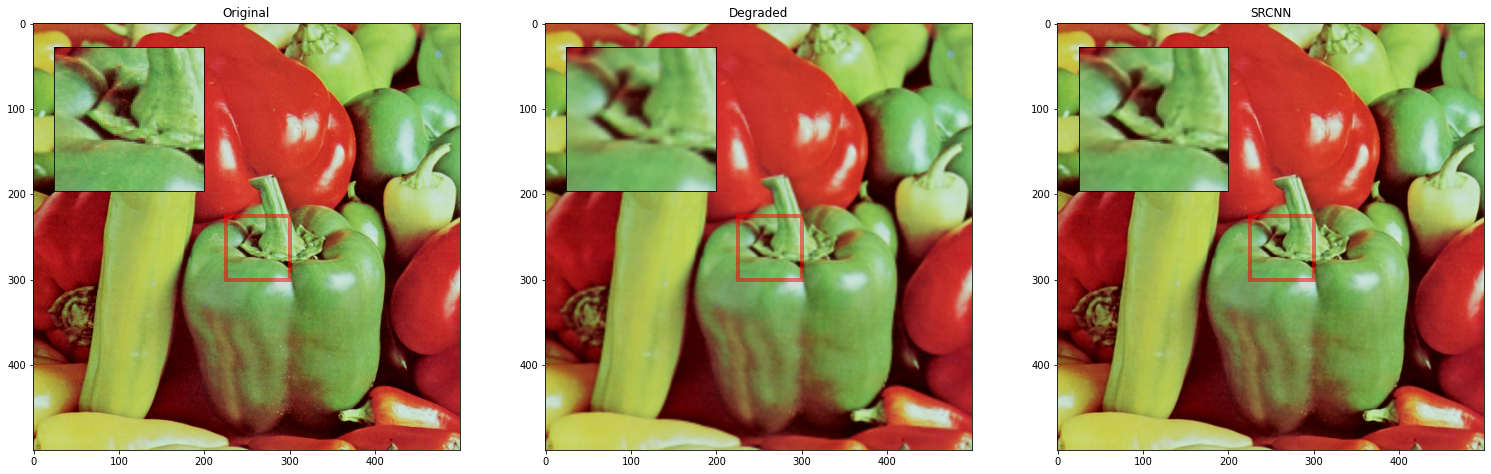

In [97]:
img_path = 'images/pepper.bmp'
borders = [225, 300, 300, 225]
save_dir = 'comparison'
display_images(img_path, borders, save_dir)

In [ ]:
os.mkdir("output") if not os.path.isdir("output") else None
os.mkdir("output/upscaled") if not os.path.isdir("output/upscaled") else None
os.mkdir("output/degraded") if not os.path.isdir("output/degraded") else None
os.mkdir("output/input") if not os.path.isdir("output/input") else None

for file in os.listdir('images'):
    input, degraded, output, _ = predict('images/{}'.format(file))
    cv2.imwrite('output/upscaled/{}'.format(file), output)
    cv2.imwrite('output/degraded/{}'.format(file), degraded)
    cv2.imwrite('output/input/{}'.format(file), input)

In [ ]:
os.mkdir("downloads") if not os.path.isdir("downloads") else None
!zip -r /content/downloads/referenceImages.zip /content/output/input
!zip -r /content/downloads/lowResolutionImages.zip /content/output/degraded
!zip -r /content/downloads/restoredImages.zip /content/output/upscaled
!zip -r /content/downloads/comparison.zip /content/comparison